In [38]:
import pandas as pd
import matplotlib.pyplot as plt
# import folium

class DatasetHandler:

    def __init__(self, filename):
        """
        Reads the data into a dataframe and does initial processing
        """
        assert isinstance(filename, str)
        assert len(filename) > 0

        self._plot = False # controls whether plots should be displayed. Useful for debugging

        try:
            self._df = pd.read_csv(filename)
        except FileNotFoundError:
            print("The file could not be found!")

    def clean_dataset(self):
        """
        Cleans the dataset i.e removes NaNs, errors, etc... and makes the dataset simpler to use.
        """
        # if we run the following, we see that Legislative District has the most number of NaN values
        self._df.isna().sum().to_frame('NaN')
        # we can fix this as follows:
        self._df['Legislative District'] = self._df['Legislative District'].map(lambda x: str(x).split('.')[0])
        # in a similar way for Vehicle Location
        # forward fill propigates the last observed values to fill the NaN slots
        self._df['Vehicle Location'] = self._df['Vehicle Location'].ffill()
        # Secondly, Legislative District is of dtype object, when it should be float so we can change it

        # We can rename the electric vehicle types for simplicity, i.e Plug-in Hybrid Electric Vehicle (PHEV) to PHEV
        ev_type = []
        for elem in self._df['Electric Vehicle Type']:
            if 'PHEV' in elem:
                ev_type.append('PHEV')
            elif 'BEV' in elem:
                ev_type.append('BEV')
            else:
                raise ValueError("Value has to be either PHEV or BEV!")
        self._df['Electric Vehicle Type'] = ev_type

        # We can do something similar for CAFV
        eligible = []
        for elem in self._df['Clean Alternative Fuel Vehicle (CAFV) Eligibility']:
            if 'Not eligible due to low battery range' == elem:
                eligible.append('Not Eligible')
            elif 'Eligibility unknown as battery range has not been researched' == elem:
                eligible.append('Unkown')
            elif 'Clean Alternative Fuel Vehicle Eligible' == elem:
                eligible.append('Eligible')
        self._df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'] = eligible

        # print(self._df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'])

    def create_graph(self, data={}):
        """
        Abstracts away the core funcitonality of the visualization code.
        """
        assert isinstance(data, dict)
        assert len(data) > 0
        assert "x" in data
        assert "y" in data

        fig, ax = plt.subplots()
        # ax  = fig.add_subplot(111)
        
        ax.set_xlabel(data.get('xlabel', 'X'))
        ax.set_ylabel(data.get('ylabel', 'Y'))
        ax.set_title(data.get('title', 'Title'))
        # ax.tick_params(axis='x', rotation=90)
        return ax

    def create_boxplot(self, data={}, **other):
        """
        Creates a boxplot
        """
        ax = self.create_graph(data)

        ax.boxplot(data["x"], labels=data["y"], **other)

        ax.tick_params(axis='x', rotation=90)
        
        if self._plot: plt.show()

    def create_barplot(self, data={}, rotate=True, **other):
        """
        Creates a barplot
        """
        ax = self.create_graph(data)

        ax.bar(data['x'], data['y'], **other)

        if rotate: ax.tick_params(axis='x', rotation=90)
        
        if self._plot: plt.show()

    def create_piechart(self, data={}, **other):
        """
        Creates a piechart
        """
        ax = self.create_graph(data)

        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.pie(data['x'], labels=data['y'], autopct='%1.1f%%', **other)
        
        if self._plot: plt.show()

    def create_map(self, data={}, **other):
        """
        Creates a map of car locations in the world
        """
        pass

In [39]:

handler = DatasetHandler("Electric_Vehicle_Population_Data.csv")
handler.clean_dataset()
handler._plot = False

years=sorted(handler._df['Model Year'].unique())
yearly=[]
for year in years:
    byyear=handler._df.loc[handler._df['Model Year'] == year].values
    yearly.append([x[10] for x in byyear])

boxplot_data = {
    'xlabel': 'Model Year',
    'ylabel': 'Electric Range',
    'title' : 'Electric Range by Model Year',
    'x': yearly,
    'y': years
}

ev_boxplot = []
for e, battery_type in enumerate(['PHEV', 'BEV'], start=1):

    # Filter the DataFrame for the current battery_type
    filtered_data = handler._df[handler._df['Electric Vehicle Type'] == battery_type]

    # Get unique makes and prepare data for box plot
    makes = sorted(filtered_data['Make'].unique())
    electric_ranges = [filtered_data[filtered_data['Make'] == make]['Electric Range'] for make in makes]

    # Create the box plot
    ev_data = {
        'xlabel': 'Make',
        'ylabel': 'Electric Range',
        'title' : f'Electric Range by Model Year for {battery_type}',
        'x': electric_ranges,
        'y': makes
    }
    ev_boxplot.append(ev_data)

# displays the makes and the number of cars in each section
maker_data = {
    'xlabel': 'Make',
    'ylabel': 'No. of Vehicles',
    'title' : 'Top 10 Different Makers',
    'x': handler._df['Make'].value_counts().head(10).index.to_list(),
    'y': handler._df['Make'].value_counts().head(10).to_list()
}

# displays the Model and the number of cars in each section
model_data = {
    'xlabel': 'Make',
    'ylabel': 'No. of Vehicles',
    'title' : 'Top 10 Different Models',
    'x': handler._df['Model'].value_counts().head(10).index.to_list(),
    'y': handler._df['Model'].value_counts().head(10).to_list()
}

car_type = {
    'title' : 'Vehicle type distribution',
    'y': handler._df['Electric Vehicle Type'].value_counts().head(10).index.to_list(),
    'x': handler._df['Electric Vehicle Type'].value_counts().head(10).to_list()
}

eligibility = {
    'title' : 'Clean Alternative Fuel Vehicle (CAFV) Eligibility',
    'y': handler._df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts().head(10).index.to_list(),
    'x': handler._df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts().head(10).to_list()
}


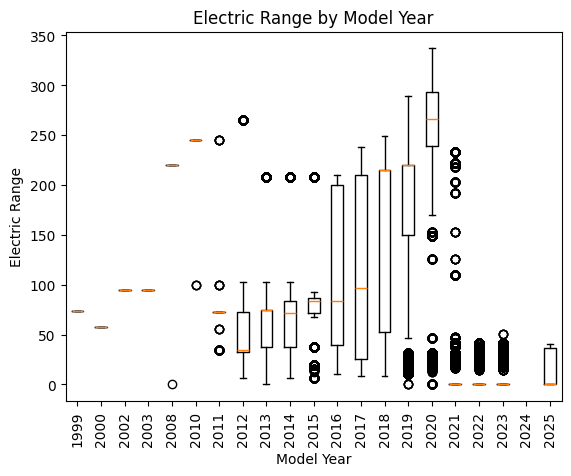

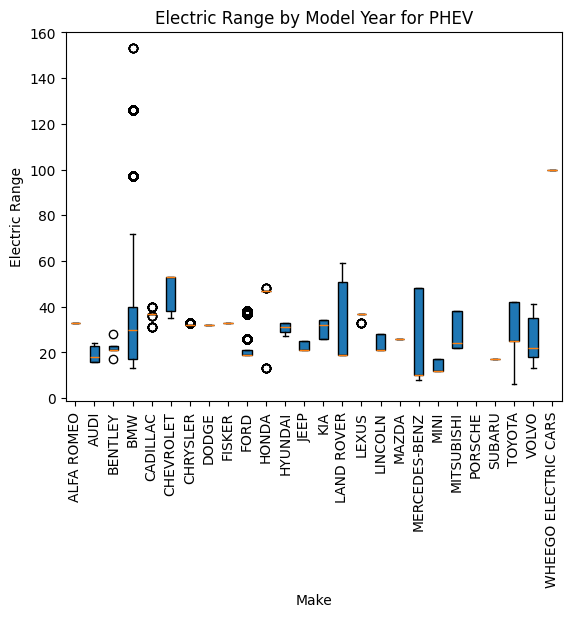

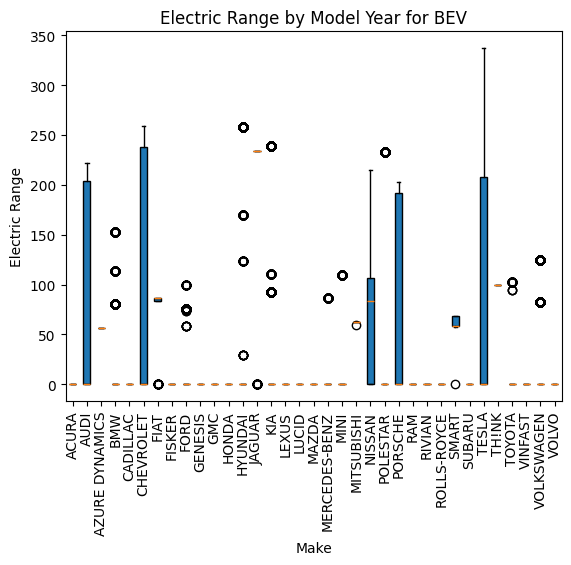

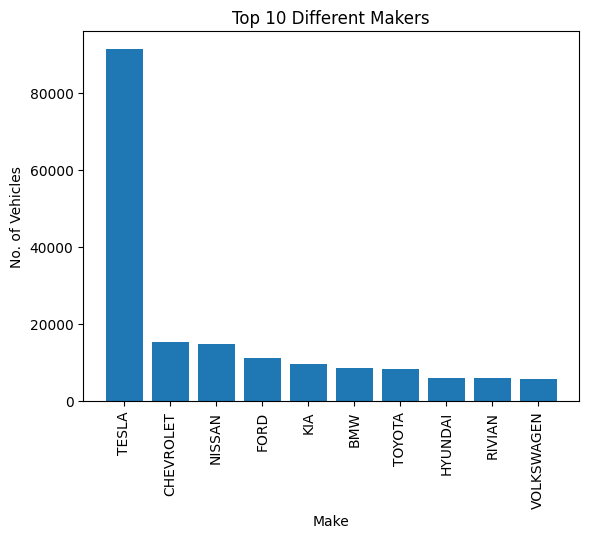

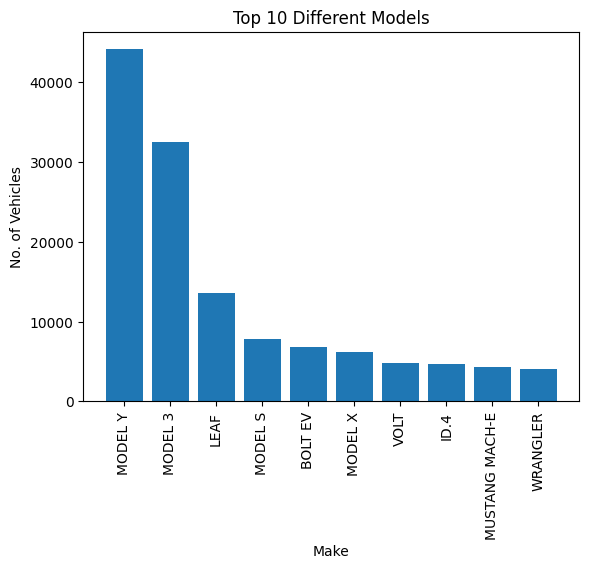

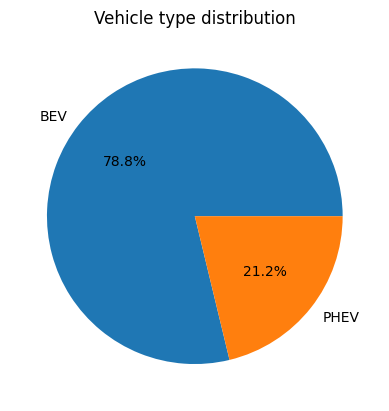

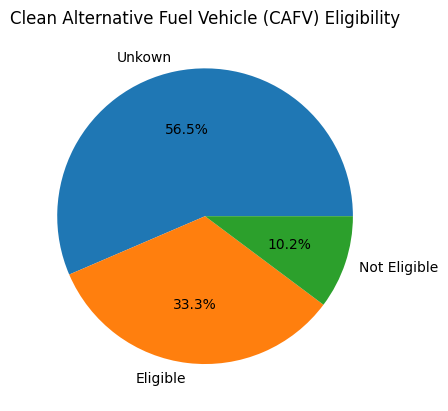

In [40]:
handler._plot = True
handler.create_boxplot(data=boxplot_data)
handler.create_boxplot(data=ev_boxplot[0], patch_artist=True)
handler.create_boxplot(data=ev_boxplot[1], patch_artist=True)
handler.create_barplot(maker_data)
handler.create_barplot(model_data)
handler.create_piechart(car_type)
handler.create_piechart(eligibility)